In [1]:
import os, sys, rdflib
import numpy as np, pandas as pd
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
import rdflib.plugins.sparql as sparql
from SPARQLWrapper import SPARQLWrapper, JSON
sys.path.append(os.path.abspath("./util"))
from misc import *

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import plotly.plotly as py, plotly.graph_objs as go
from plotly.graph_objs import *

from sklearn import metrics
from hdbscan import HDBSCAN
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering, AgglomerativeClustering

In [2]:
%%time
%store -r uri_type
if "uri_type" not in locals():
    dbpedia_type_graph = rdflib.Graph()
    dbpedia_type_graph.parse('./dataset/instance_types_en_uris_it.nt', format="nt" )
    dbpedia_type_graph.parse('./dataset/instance_types_en.nt', format="nt" )

CPU times: user 2.96 s, sys: 953 ms, total: 3.91 s
Wall time: 6.3 s


In [3]:
# %%time
# # mapping freebase's mids to dbpedia's resources
# mid2dbpedia = dict()
# file_path = "./dataset/Release/freebase_code_names.txt"
# with open(file_path, "r") as mapping_file:
#     for line in mapping_file:
#         mid, dbp_resource = line.replace("\n", "").split("\t")
#         val = mid2dbpedia.get(mid, [])
#         mid2dbpedia[mid] = val + [dbp_resource]

### Training the Model

In [4]:
walks_path = "./dataset/embedding_5_7_dbpedia_3.9_infobox_properties_no_literal.nt.txt"

vocab_sequences = get_sequences(walks_path)
train_sequences = get_sequences(walks_path)

model = Word2Vec(min_count=1, window=5, negative=5, size=100)

model.build_vocab(vocab_sequences)
model.train(train_sequences)

9023321

In [5]:
%store -r uri_type
if "uri_type" not in locals():
    uri_type = dict()
    for uri in model.vocab:
        types = {row[0].n3() for row in get_types(uri, dbpedia_type_graph)}
        if len(types) > 0:
            uri_type[uri] = types
    %store uri_type

In [6]:
embeds = np.asarray([model[uri] for uri in uri_type])
uris   = np.asarray([uri for uri in uri_type])
labels = np.asarray([1 if is_person(uri, uri_type) else 0 for uri in uri_type])

random_idx  = np.random.choice(range(len(embeds)), len(embeds), replace=False)
split_point = len(embeds) * 70 / 100
training_idx, test_idx = random_idx[:split_point], random_idx[split_point:]

embeds_train, embeds_test = embeds[training_idx], embeds[test_idx]
uris_train,   uris_test   = uris[training_idx]  , uris[test_idx]
labels_train, labels_test = labels[training_idx], labels[test_idx]

ground_truth = get_ground_truth(uris, uri_type)

In [7]:
%%time
naive_bayes = GaussianNB()
rbf_svm     = SVC(gamma=2, C=1)
rand_forest = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
ada_boost   = AdaBoostClassifier()

naive_bayes.fit(embeds_train, labels_train)
rbf_svm.fit(embeds_train, labels_train)
rand_forest.fit(embeds_train, labels_train)
ada_boost.fit(embeds_train, labels_train)

naive_bayes_pred = np.array([naive_bayes.predict([emb]) for emb in embeds_test])
rbf_svm_pred     = np.array([rbf_svm.predict([emb]) for emb in embeds_test])
rand_forest_pred = np.array([rand_forest.predict([emb]) for emb in embeds_test])
ada_boost_pred   = np.array([ada_boost.predict([emb]) for emb in embeds_test])

classifier = RandomForestClassifier(n_estimators=15)
classifier.fit(embeds_train, labels_train)
labels_pred = np.array([classifier.predict([emb]) for emb in embeds_test])

CPU times: user 1h 47min 18s, sys: 29.1 s, total: 1h 47min 47s
Wall time: 1h 49min 13s


In [8]:
metrics_df = pd.concat([
    binclass_metrics(labels_test, labels_pred, name="Random Forest"),
    binclass_metrics(labels_test, naive_bayes_pred, name="Naive Bayes"),
    binclass_metrics(labels_test, rbf_svm_pred, name="RBF SVM"),
    binclass_metrics(labels_test, ada_boost_pred, name="AdaBoost")
])

metrics_df

,Accuracy,Log-loss,Precision,Recall,F1-score,Matthews
Random Forest,0.890301,3.788874,0.889162,0.665429,0.761196,0.704140
Naive Bayes,0.351655,22.393557,0.275513,0.900622,0.421947,0.071601
RBF SVM,0.879593,4.158704,0.921001,0.592552,0.721139,0.674577
AdaBoost,0.848586,5.229670,0.809110,0.554541,0.658063,0.581772


Confusion matrix, without normalization


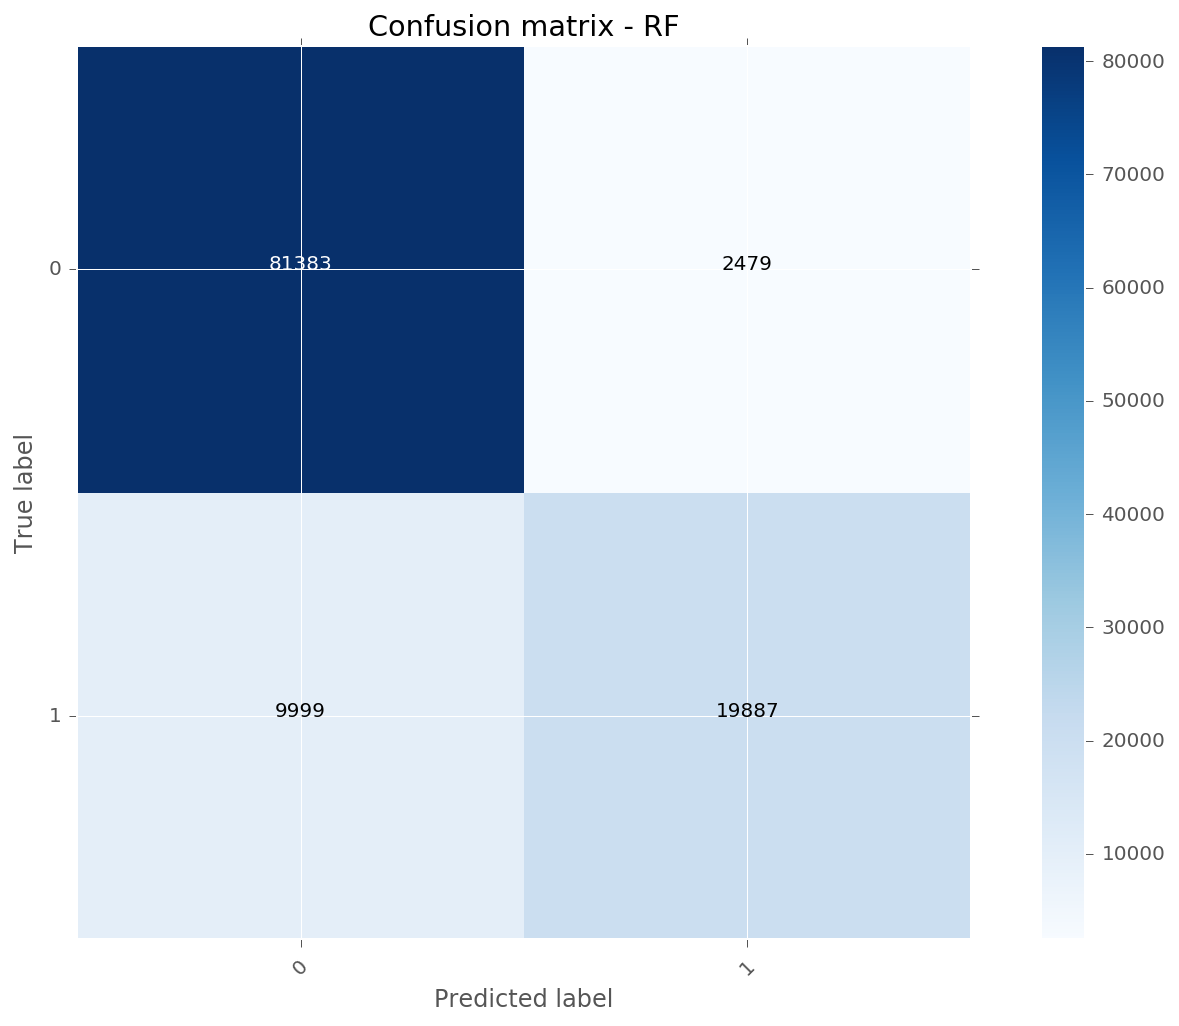

In [9]:
plt.rcParams["figure.figsize"] = [10, 7]

cnf_matrix = metrics.confusion_matrix(labels_test, labels_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1], title='Confusion matrix - RF')
plt.show()